## 1. Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

The UCI Machine Learning Repository создали набор данных электронных транзакций, содержащий фактические транзакции за 2010 и 2011 годы. Датасет содержит все транзакции, произошедшие за период с 01/12/2010 по 09/12/2011, для базирующейся в Великобритании компании, занимающейся розничной онлайн-торговлей. Компания в основном продаёт уникальные подарки на все случаи жизни.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.

## 2. Знакомство с данными. 

In [1]:
#импортируем все необходимые для проекта библиотеки 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn import mixture
from sklearn import manifold
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

warnings.filterwarnings("ignore")

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала посмотрим на данные:

In [2]:
data = pd.read_csv('data/customer_segmentation_project.csv',encoding="ISO-8859-1",
                   dtype={'CustomerID': str,'InvoiceID': str}
                   )
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


В данных имеются пропуски.

Преобразуем дату в формат datetime:


In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
#посмотрим за какой период представлены данные
data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

Изучим параметры количества заказов и цены:

In [5]:
print(data.describe())

            Quantity      UnitPrice
count  541909.000000  541909.000000
mean        9.552250       4.611114
std       218.081158      96.759853
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000


Видно, что в таблице есть отрицательное кол-во заказов - скорее всего это возвраты. Также есть товары с нулевой стоимостью

Посмотрим сколько уникальных клиентов и стран содержится в таблице:


In [6]:
print(len(data['CustomerID'].unique())-1)
print(len(data['Country'].unique())-1)

4372
37


## 3. Предобработка и очистка данных

На этом этапе подготовим  датасет для дальнейшего моделирования, произведя очистку данных.


Начнем с пропусков. 
Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалим строки, содержащие пропуски в этих столбцах.

In [7]:
#удаляем пропуски во всей таблице
data = data.dropna()
#посмотрим сколько осталось строк
data.shape

(406829, 8)

Следом за пропусками удалим и дубликаты:

In [8]:
#удаляем дубликаты во всей таблице
data = data.drop_duplicates()
#посмотрим сколько осталось строк
data.shape

(401604, 8)

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [9]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Посмотрим сколько транзакций из таблицы negative_quantity содержат в номере заказа признак возврата:

In [10]:
negative_quantity['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0).value_counts()

1    8872
Name: InvoiceNo, dtype: int64

Все записи имеют признак возврата.

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [11]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае:

In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x: 1 if x[0][0] == 'C' else 0
    )
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
...,...,...,...,...
22185,18283,579673,50,0
22186,18283,580872,50,0
22187,18287,554065,29,0
22188,18287,570715,38,0


В таком виде гораздо проще оценить реальное количество возвратов. Посмотрим какой процент заказов возращают:

In [13]:
nb_products_per_basket['order_canceled'].value_counts(normalize=True)

0    0.835331
1    0.164669
Name: order_canceled, dtype: float64

Более 16 % уникальных заказов являются возвратами.

Давайте поближе взглянем на отмененные заказы:


In [14]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [15]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Выдвигаем гипотезу: для каждой отменённой транзакцию в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.
Проверим её:

In [16]:
#датафрейм продаж
sales = data[['StockCode', 'Quantity', 'CustomerID']]
#датафрейм возвратов
returns = negative_quantity[['StockCode', 'Quantity', 'CustomerID']]
#меняем отрицательные значенияна положительные
returns['Quantity'] = -returns['Quantity']
#сравнимаем записи в датафреймах
n_matched = returns.apply(tuple, axis=1).isin(sales.apply(tuple, axis=1)).sum()
#выводим кол-во несовпадений
print(f'Количество несовпадений: {negative_quantity.shape[0] - n_matched}')

Количество несовпадений: 5626


Итак, гипотеза не подтвердилась. Давайте посмторим контр-пример, на котором "споткнулась" наша гипотеза. Посмотрим на клиента с идентификатором 14527: 

In [17]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [18]:
#проводим такое же сравнение, но удалив записи со скидкой
sales = data[['StockCode', 'Quantity', 'CustomerID']]
returns = negative_quantity[['StockCode', 'Quantity', 'CustomerID']]
returns = returns[returns['StockCode'] != 'D']
n_matched = returns.apply(tuple, axis=1).isin(sales.apply(tuple, axis=1)).sum()
print(f'Количество несовпадений: {negative_quantity.shape[0] - n_matched}')

Количество несовпадений: 77


Гипотеза не подтвердилась.Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [19]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара).

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции:

In [20]:
#напишем функцию для создания нового признака
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

#применяем функцию к исходной таблице
quantity_canceled = get_quantity_canceled(data)
#создаем новый признак
data['quantity_canceled'] = quantity_canceled
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,quantity_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0


Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара:

In [21]:
df = data[data.Quantity >= 0]
df.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды:

In [22]:
#с помощью регулярных выражений находим записи с символами
data_special_transactions = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
print(data_special_transactions['StockCode'].nunique())
print(data_special_transactions['StockCode'].unique())

6
['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']


Итак, в таблице есть еще 6 различных видов транзакций.

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны:

In [23]:
#удаляем записи со специальными видами транзакций
df = df.drop(data_special_transactions.index)
data.shape[0]

401604

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

Таких транзакций  менее 1 %, поэтому от них можно просто избавиться:

In [24]:
#оставляем только записи где цена не равна нулю
df = df[df['UnitPrice'] != 0]
df.shape

(391150, 9)

## 4. Разведывательный анализ данных

Теперь  займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран:

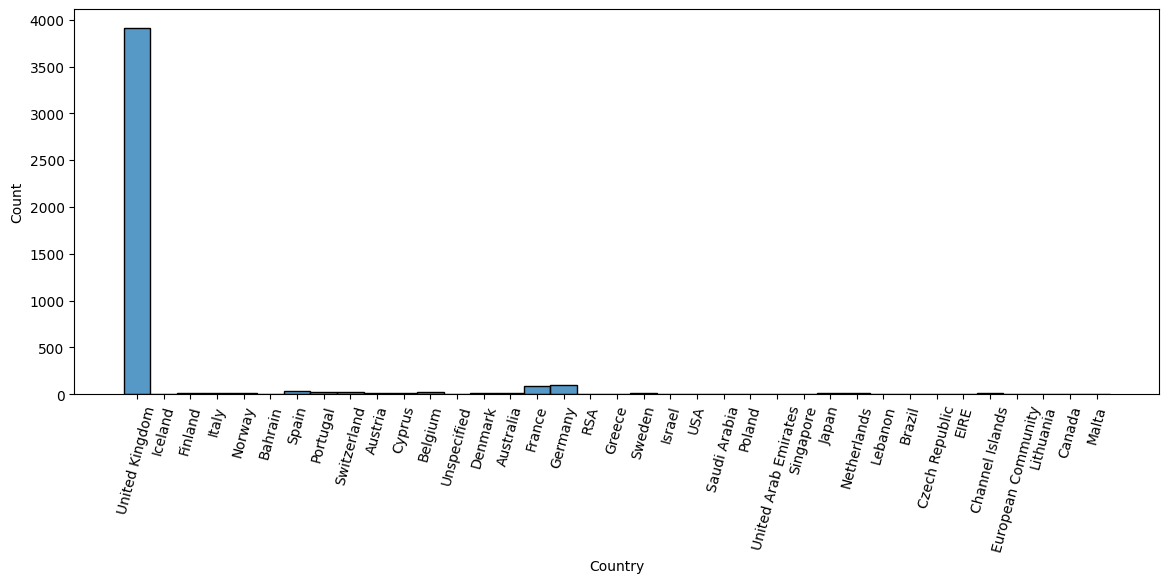

In [25]:
fig, ax = plt.subplots(figsize=(14, 5))
hist = sns.histplot(data=df.groupby(by=['CustomerID', 'Country'], as_index=False)['InvoiceDate'].count(),
                    x='Country'
                    );
hist.xaxis.set_tick_params(rotation=75)

Большая часть клиентов из Великобритании, а также Германии и Франции.

Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [26]:
df['TotalPrice'] = (df['Quantity']-df['quantity_canceled'])*df['UnitPrice']

Построим визуализацию по общему доходу из разных стран:

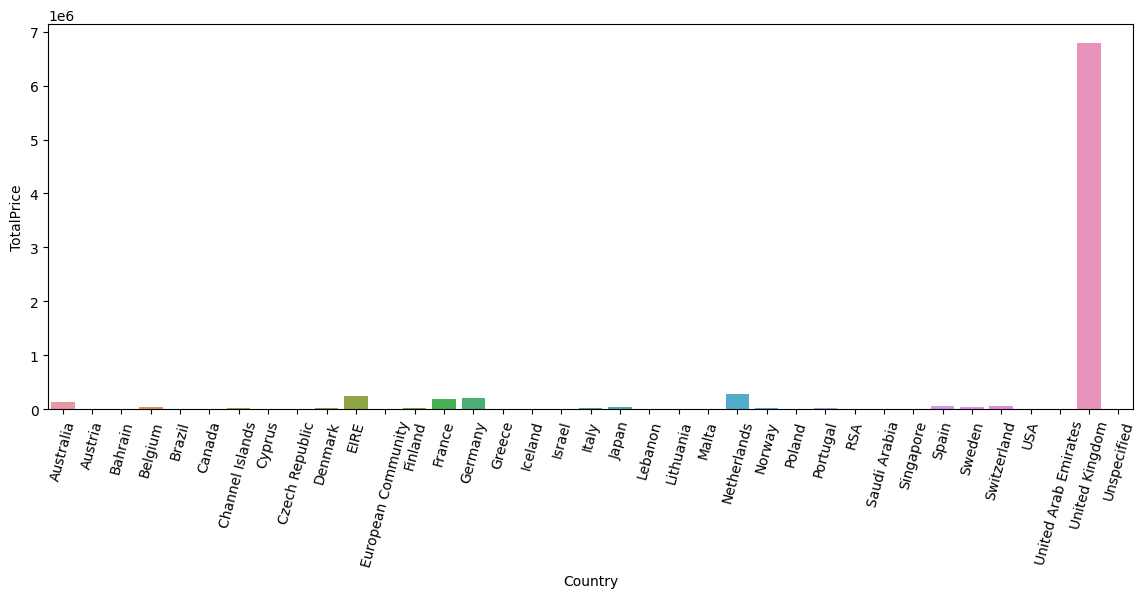

In [27]:
fig, ax = plt.subplots(figsize=(14, 5))
hist = sns.barplot(data=df.groupby(by='Country', as_index=False)['TotalPrice'].sum(),
                    x='Country', y = 'TotalPrice'
                    );
hist.xaxis.set_tick_params(rotation=75)

Интересно, что Нидерланды находятся на шестом месте по количеству заказов, однако из-за того что эти заказы оптовые, по выручке Нидерланды находятся на втором месте.

Теперь займёмся временными характеристиками.

Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки и построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам:

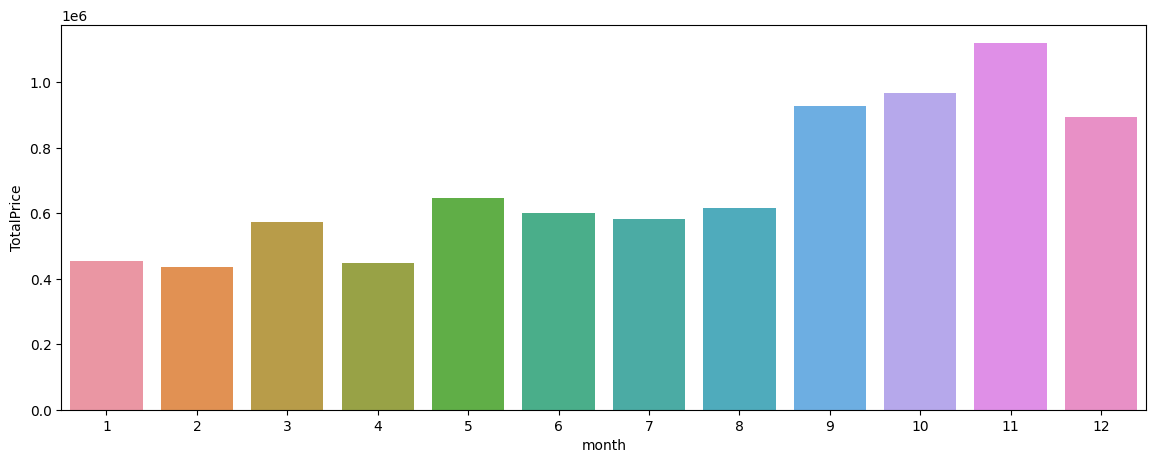

In [28]:
df['month'] = df['InvoiceDate'].dt.month
df['week_day'] = df['InvoiceDate'].dt.weekday
df['hour'] = df['InvoiceDate'].dt.hour

fig = plt.subplots(figsize=(14, 5))
hist = sns.barplot(data=df.groupby(by='month', as_index=False)['TotalPrice'].sum(),
                    x='month', y = 'TotalPrice'
                    );

Самый "успешный" месяц - ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим визуализацию, отражающую распределение среднего количества заказов по дням недели:

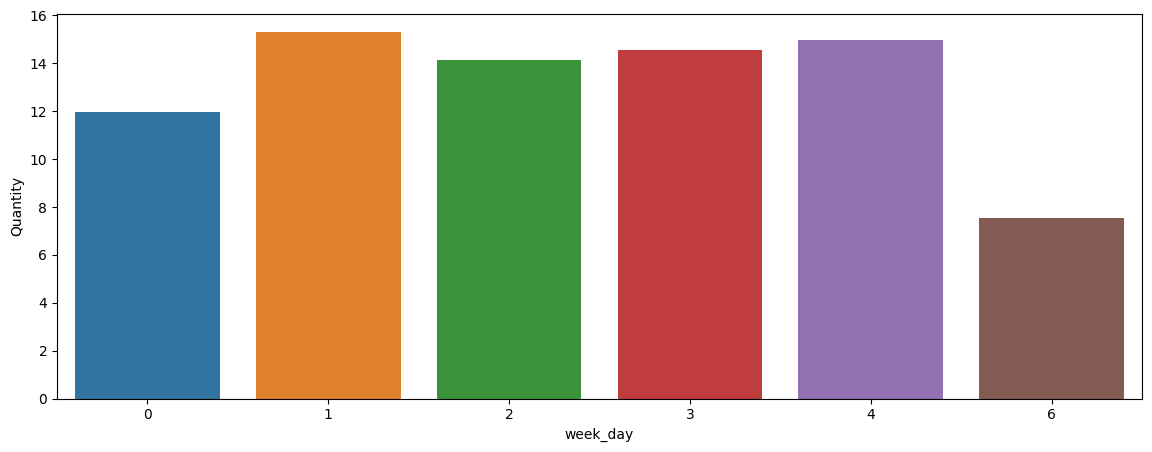

In [29]:
fig = plt.subplots(figsize=(14, 5))
hist = sns.barplot(data=df.groupby(by='week_day', as_index=False)['Quantity'].mean(),
                    x='week_day', y = 'Quantity'
                    );

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются.

Сгруппируем данные по часам совершения транзакции и найдём количество заказов на каждый час:

In [30]:
df.groupby(by=['hour'])['Quantity'].count()

hour
6         1
7       375
8      8624
9     21787
10    37558
11    48209
12    70716
13    62800
14    53052
15    44615
16    23626
17    12897
18     2884
19     3229
20      777
Name: Quantity, dtype: int64

Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов. С 21 часа до 6 утра (не включительно) заказы не поступают.

## 5. RFM-сегментация клиентов: часть 1

Нам необходимо сформировать признаки, на основе которых  будем производить сегментацию клиентов.

Для этого воспользуемся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-ого клиента рассчитывается как разница между датой последнего заказа и точкой отсчета, переведенная в дни. В качестве точки отсчета берем дату на 1 день "старше", чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime - '2011-12-10').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.

* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [81]:
rfm = pd.DataFrame()

rfm['Recency'] = (pd.to_datetime('2011-12-10') - 
                  df.groupby(by='CustomerID')['InvoiceDate'].max()
                  ).dt.days
rfm['Monetary'] = df.groupby(by='CustomerID')['TotalPrice'].sum()

#список уникальных товаров
unique_InvoiceNo = []
#добавляем в список кол-во уникальных товаров для каждого клиента
for i in df.groupby(by=['CustomerID'])['InvoiceNo'].unique():
    i = len(i)
    unique_InvoiceNo.append(i)
    
rfm['Frequency'] = np.array(unique_InvoiceNo)

rfm.head(3)

,Recency,Monetary,Frequency
CustomerID,,,
12346,325,0.00,1
12347,2,4310.00,7
12348,75,1437.24,4


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

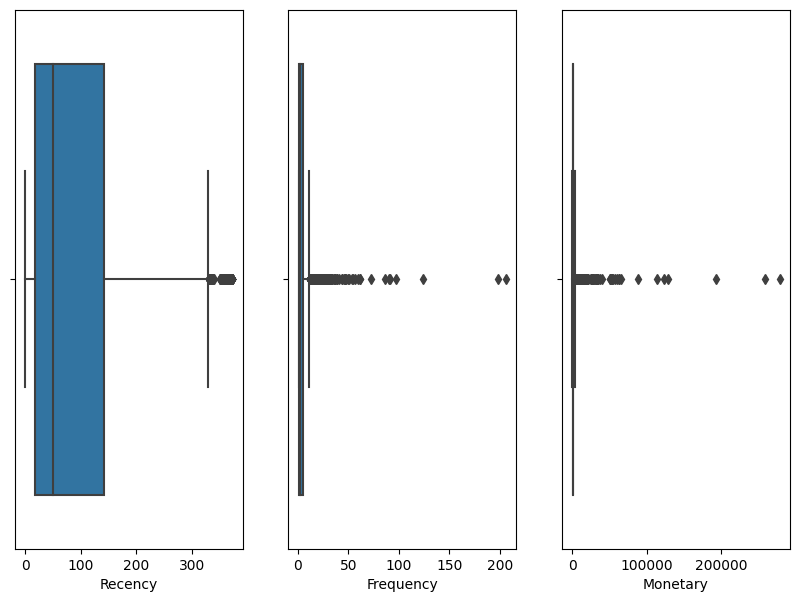

In [79]:
fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(10, 7))
sns.boxplot(data=rfm, x='Recency',ax=axes[0])
sns.boxplot(data=rfm, x='Frequency',ax=axes[1])
sns.boxplot(data=rfm, x='Monetary',ax=axes[2]);

Из графиков видно, что есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов:


In [33]:
#оставляем только данные, которые входят в 95% значений параметров
rfm_cleaned = rfm[(rfm['Frequency'] <= rfm['Frequency'].quantile(0.95)) &
                 (rfm['Monetary'] <= rfm['Monetary'].quantile(0.95))]

Посмотрим на диаграммы после удаления выбросов:


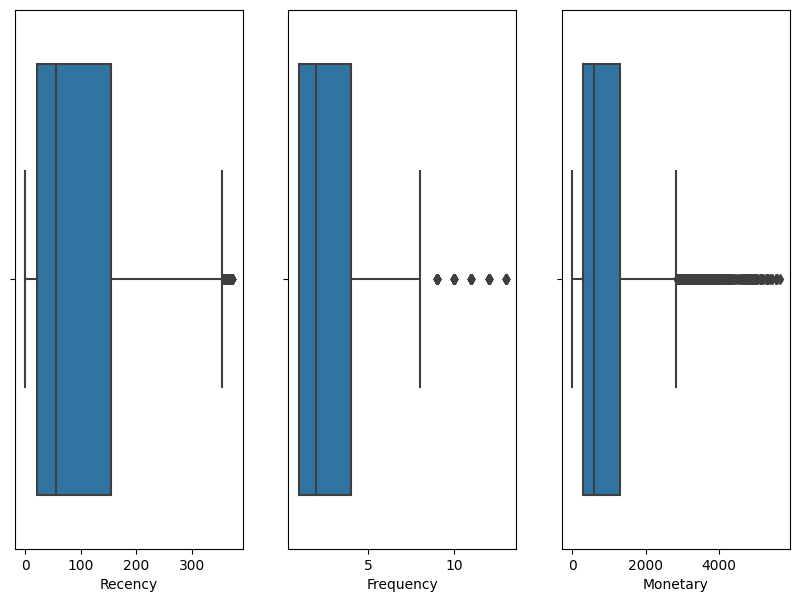

In [80]:
fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(10, 7))
sns.boxplot(data=rfm_cleaned, x='Recency',ax=axes[0])
sns.boxplot(data=rfm_cleaned, x='Frequency',ax=axes[1])
sns.boxplot(data=rfm_cleaned, x='Monetary',ax=axes[2]);

Диаграммы менее "сжатые", что говорит о меньшем количестве выбросов.

Итак, перейдём к кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


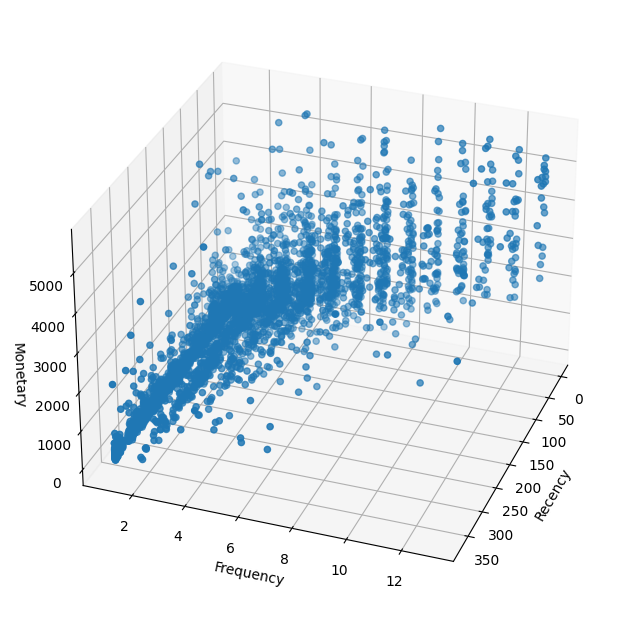

In [35]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_cleaned['Recency'].to_list(), 
    rfm_cleaned['Frequency'].to_list(),
    rfm_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Призовём на помощь методы снижения размерности.


Начнём с метода главных компонент (PCA). Для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Стандартизируем данные и обучим PCA на rfm таблице:


In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#инициализируем стандартизатор
scaler = StandardScaler()
#обучаем метод и стандартизируем таблицу
rfm_scaled = scaler.fit_transform(rfm_cleaned)
#инициализируем метод главных компонент
pca = PCA(n_components=2)
#обучаем метод и трансформируем таблицу
pca.fit(rfm_scaled)
rfm_pca = pca.transform(rfm_scaled)

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

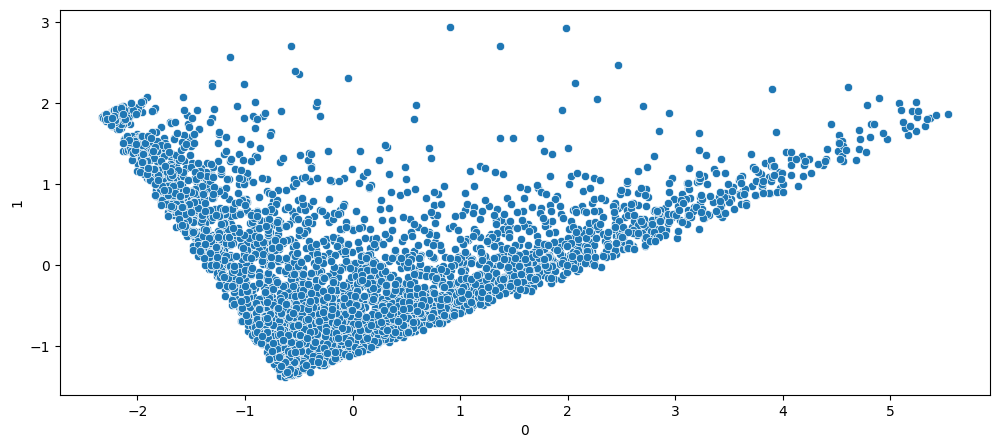

In [37]:
fig = plt.figure(figsize=(12, 5))
#запишем главные компоненты в виде датафрейма
rfm_pca_df = pd.DataFrame(rfm_pca)
sns.scatterplot(data=rfm_pca_df, x = rfm_pca_df[0], y = rfm_pca_df[1]);

Попробуем разделить это пространство главных компонент на сегменты. 

Воспользуемся методом k-means. 

Подберём оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно:

[0.5002955980290275, 0.524229665654148, 0.4975527884563785, 0.4545444972935232, 0.4480060903903762, 0.42029546965842224, 0.4207447292287864, 0.4089571765040919, 0.39784347736723646]


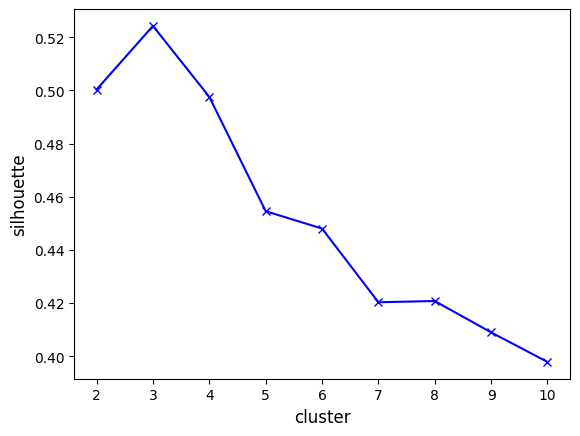

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#создаём список значений коэффициента силуэта
silhouettes = []
#перебираем количество кластеров
for i in range(2, 11):
    #обучаем k-means 
    k_means =  KMeans(n_clusters=i, random_state=42).fit(rfm_pca)
    #сичтаем коэффициент силуэта
    silhouette = silhouette_score(rfm_pca, k_means.labels_, metric='euclidean')
    #записываем коэффициент силуэта в список
    silhouettes.append(silhouette)

#визуализируем значени коэффициента силуэта и выведем его значения    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouettes, 'xb-')
print(silhouettes)

Итак, оптимальное количество кластеров - 3, со значением коэффициента силуэта - 0.52.

Теперь попробуем EM-алгоритм, также перебрав разное кол-во кластеров:

[0.3424840508391378, 0.43606149772658104, 0.3501027804470042, 0.24696924689017877, 0.2666696444349457, 0.19885132009228113, 0.19687980172305727, 0.15762651806881495, 0.1094449517207094]


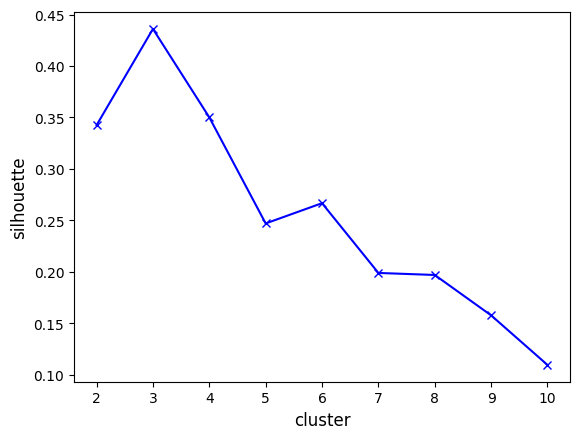

In [39]:
from sklearn.mixture import GaussianMixture

silhouettes = []
for i in range(2, 11):
    model =  GaussianMixture(n_components=i, random_state=42).fit_predict(rfm_pca)
    silhouette = silhouette_score(rfm_pca, model, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouettes, 'xb-')
print(silhouettes)

EM-алгоритм также разбил данные на 3 кластера, но коэффициент силуэта оказался меньше - 0.42.

K-means сработал лучше, обучим на нём итоговую модель и добавим кластеры в rfm таблицу:


In [40]:
k_means =  KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_pca)
#добавляем признак label(кластер)
rfm_cleaned.loc[:, 'label'] = k_means.labels_
#постморим на распределение клиентов по кластерам
rfm_cleaned.label.value_counts()

2    2269
0     999
1     776
Name: label, dtype: int64

Визуализируем результаты кластеризации:

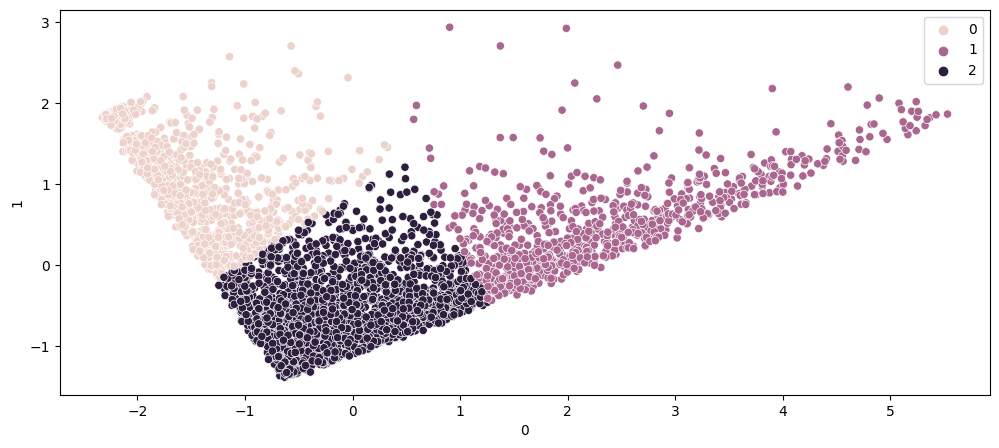

In [41]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_pca_df, x = rfm_pca_df[0], y = rfm_pca_df[1],hue=k_means.labels_);

Итак, у нас есть три сегмента клиентов. Составим профиль для этих сегментов, сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков:

In [42]:
print(rfm_cleaned.groupby(by='label')['Recency'].mean())
print(rfm_cleaned.groupby(by='label')['Frequency'].mean())
print(rfm_cleaned.groupby(by='label')['Monetary'].mean())

label
0    253.474474
1     31.943299
2     51.221684
Name: Recency, dtype: float64
label
0    1.403403
1    7.068299
2    2.329220
Name: Frequency, dtype: float64
label
0     386.277297
1    2657.746997
2     660.068947
Name: Monetary, dtype: float64


Исходя из этих данных, можно сделать вывод:

* Нулевой(0) кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

* Первый(1) кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

* Второй(2) кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

### 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому попытаемся модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Однако, PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

In [45]:
# импортируем класс TSNE из модуля manifold библиотеки sklearn
from sklearn.manifold import TSNE
# создаём объект класса TSNE
# n_components — размерность нового пространства
tsne = TSNE(n_components=2, perplexity=50,random_state=100)
# обучаем модель на данных 
tsne.fit(rfm_scaled)
# применяем уменьшение размерности к матрице 
rfm_tsne = tsne.fit_transform(rfm_scaled)

Визуализировав пространство после декомпозиции с помощью t-SNE, получим следующую картину:


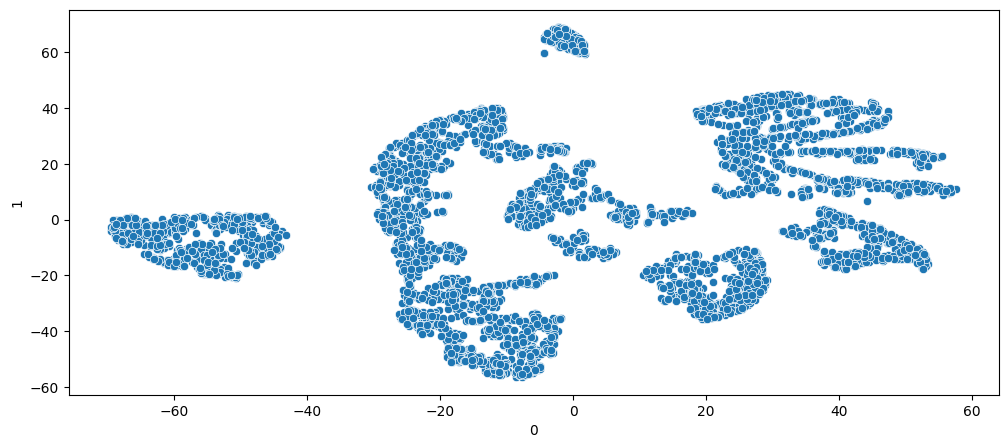

In [46]:
fig = plt.figure(figsize=(12, 5))
#запишем декомпозированные данные в датафрейм
rfm_tsne_df = pd.DataFrame(rfm_tsne)
sns.scatterplot(data=rfm_tsne_df, x = rfm_tsne_df[0], y = rfm_tsne_df[1]);

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.

Из различных варинтов кластеризации лучше всего себя показал алгоритм алгомеративной кластеризации (AgglomerativeClustering). Подберём оптимальное кол-во кластеров:

In [47]:
from sklearn.cluster import AgglomerativeClustering

silhouettes = []
 
for cluster in range(2,9,1):
        agglomerative = AgglomerativeClustering(n_clusters=cluster).fit_predict(rfm_tsne)
        sil_score = silhouette_score(rfm_tsne, agglomerative, metric='euclidean')
        silhouettes.append((cluster, sil_score,len(set(agglomerative))))
        
df_hierarchical = pd.DataFrame(silhouettes, columns=['cluster', 'sil_score','number_of_clusters'])
df_hierarchical

,cluster,sil_score,number_of_clusters
0,2,0.405499,2
1,3,0.384634,3
2,4,0.439424,4
3,5,0.489025,5
4,6,0.505161,6
5,7,0.516577,7
6,8,0.505868,8


Оптимальное количество кластеров - 7, коэффициент силуэта - 0.52.

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных и добавим кластеры в rfm таблицу:

In [48]:
agglomerative = AgglomerativeClustering(n_clusters=7).fit_predict(rfm_tsne)
rfm_cleaned.loc[:, 'label'] = agglomerative
#посмотрим на распределение кластеров
rfm_cleaned.label.value_counts()

1    904
2    725
0    719
4    651
3    508
5    423
6    114
Name: label, dtype: int64

Визуализируем результаты кластеризации:

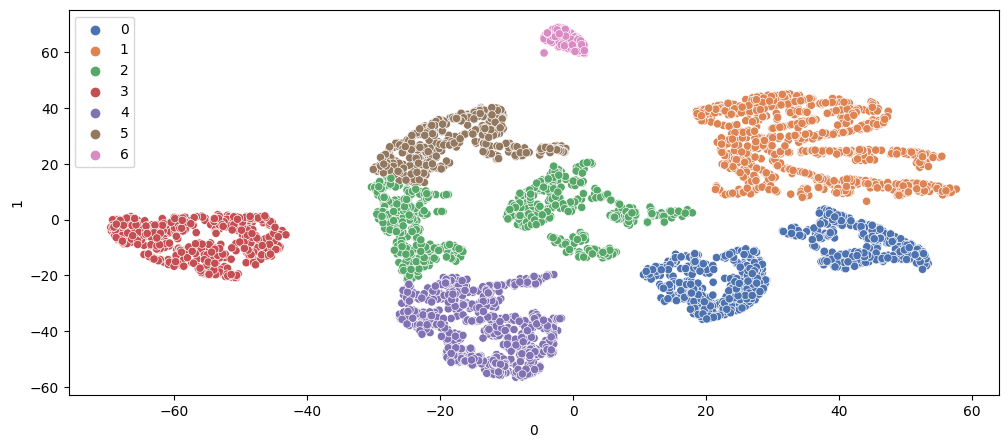

In [49]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_tsne_df, x = rfm_tsne_df[0], y = rfm_tsne_df[1],
                hue=agglomerative, palette='deep');


Итак, у нас есть 7 сегментов клиентов. Составим профиль для этих сегментов:

In [50]:
print(rfm_cleaned.groupby(by='label')['Recency'].mean())
print(rfm_cleaned.groupby(by='label')['Frequency'].mean())
print(rfm_cleaned.groupby(by='label')['Monetary'].mean())

label
0     44.394993
1     32.734513
2    168.929655
3     37.950787
4     45.637481
5    282.728132
6    365.456140
Name: Recency, dtype: float64
label
0    3.468707
1    6.803097
2    1.764138
3    2.000000
4    1.000000
5    1.094563
6    1.043860
Name: Frequency, dtype: float64
label
0     967.386912
1    2418.338960
2     545.556110
3     546.600571
4     331.322043
5     351.127565
6     235.531930
Name: Monetary, dtype: float64


Исходя из этих данных, можно сделать вывод:

* 0 кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.

* 1 кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

* 2 кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.

* 3 кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».

* 4 кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму.

* 5 кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.

* 6 кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку не так просто.

Мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Сведём задачу кластеризации к задаче классификации. У нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20:

In [52]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_cleaned.drop('label',axis=1) #очищенная RFM-таблица
y = rfm_cleaned['label'] #метки кластеров, предсказанные ранее

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут. Поэтому сразу возьмём ансамблевые алгоритмы. 


Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier). С помощью лучшей модели сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy:

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#задаем сетку параметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
#подбираем наилучшие параметры для случайного леса
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
#обучаем наилучшую модель 
grid_search.fit(X_train, y_train)
#предсказываем целевую переменную 
y_test_pred = grid_search.predict(X_test)
#выведем метрику модели
print('accuracy на тестовом наборе: {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
#выведем параметры модели
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на тестовом наборе: 0.9864029666254636
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100}


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier).
С помощью лучшей модели сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy:



In [54]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
  
grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('accuracy на тестовом наборе: {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на тестовом наборе: 0.9888751545117429
Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


Пусть и незначительно, но метрика все же увеличилась.

## 8. Итоги

Исходнные данные были предобработаны, проведён разведывательный анализ и создание новых признаков.

От исходной таблицы транзакций перешли к rfm-таблице, которую декомпозировали с помощью t-SNE до двух компонент. 

С помощью алгомеративной кластеризации разбили новое пространство на 7 кластеров. Составили описательные характеристики клиентов для разных кластеров.

Справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. 

Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.